In [1]:
# Data processing
import numpy as np
import pandas as pd
import xarray as xr
import iris
import iris.pandas
import warnings
warnings.filterwarnings('ignore', module='iris')
import dateutil.parser
from datetime import datetime, timedelta
from pathlib import Path
from shapely.geometry import Point, Polygon
# Visualization
import cartopy.util
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
# Plotting parameters
plt.rcParams['mathtext.default'] = 'regular'
def m2km(x, pos):
    '''Convert meters to kilometers when plotting axis labels'''
    return int(x*1e-3) #'{:1.1f}'.format(x*1e-3)
savefig = False
# Species names
str_c2h6 = '$C_2H_6$'; str_c3h8 = '$C_3H_8$'
str_nc4h10 = '$nC_4H_{10}$'; str_ic4h10 = '$iC_4H_{10}$'
str_nc5h12 = '$nC_5H_{12}$'; str_ic5h12 = '$iC_5H_{12}$'
str_meono2 = '$MeONO_2$'; str_sbuono2 = '2-$BuONO_2$'
str_n2peono2 = '2-$PenONO_2$'; str_n3peono2 = '3-$PenONO_2$'; str_ipeono2 = '3-Methyl-2-$BuONO_2$'

#### Read data

In [2]:
path_to_atom = Path('../../../../../../obs/ATom/nc/data')
# Select flights
fname_atom_flight = 'MER-WAS_DC8_201608*.nc'
# Read ATom data
atom_dsinf = xr.open_mfdataset(sorted(path_to_atom.glob(fname_atom_flight)), decode_times=True)
atom_dsmms = xr.open_mfdataset(sorted(path_to_atom.glob(fname_atom_flight)), group='MMS', decode_cf=True)
atom_dswas = xr.open_mfdataset(sorted(path_to_atom.glob(fname_atom_flight)), group='WAS', decode_cf=True)

In [3]:
# Choose UKCA run
ukca_run_name = 'az166a'
ukca_run_yrmn = 'pm2016aug'
compared_common_id = '160801_160823_1608_merge'
path_to_ukca = Path('../../../../processed') / ukca_run_name
fname_ukca_run = f'{ukca_run_name}_{ukca_run_yrmn}_relvl.nc'
# Read UKCA data
cb_c2h6 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'c2h6')
cb_c3h8 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'c3h8')
cb_nc4h10 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'nc4h10')
cb_ic4h10 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'ic4h10')
cb_nc5h12 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'nc5h12')
cb_ic5h12 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'ic5h12')
cb_meono2 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'meono2')
cb_sbuono2 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'sbuono2')
cb_n2peono2 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'n2peono2')
cb_n3peono2 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'n3peono2')
cb_ipeono2 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'ipeono2')
# Load UKCA geospatial coordinates
ukca_lats = iris.load_cube(str(Path('../../../../data') / 'ukca_coords_n96e_marcus_180705.nc'), 'mass_fraction_of_ozone_in_air').coord('latitude')
ukca_lons = iris.load_cube(str(Path('../../../../data') / 'ukca_coords_n96e_marcus_180705.nc'), 'mass_fraction_of_ozone_in_air').coord('longitude')

In [4]:
# Path to figures
path_to_figs = Path('../../../../../../results') / ukca_run_name / compared_common_id
path_to_figs.mkdir(exist_ok=True) # create a new folder if it doesn't exist

#### Select geographical region for spacial averaging

In [5]:
# Extract datetimes from ATom data
atom_datetime = atom_dsinf.time.values.astype('<M8[us]').astype(datetime)
atom_date_strt = atom_datetime[0]
atom_date_stop = atom_datetime[-1]
# Extract spatial coordinates from ATom data
sample_lats = np.asarray(atom_dsmms.G_LAT.data) 
sample_lons = np.asarray(atom_dsmms.G_LONG.data+360)
sample_alts = np.asarray(atom_dsmms.G_ALT.data)
# Create UKCA lat lon grid
grid_lons, grid_lats = np.meshgrid(ukca_lons.points, ukca_lats.points)

In [6]:
# Define a geographical region
r1_llon, r1_ulon = 195.9375, 205.3125
r1_llat, r1_ulat = 21.875, 53.125
r1 = Polygon([(r1_llon, r1_llat), (r1_llon, r1_ulat), (r1_ulon, r1_ulat), (r1_ulon, r1_llat)]) # Anchorage-Kona

r2_llon, r2_ulon = 216.5625, 231.5625
r2_llat, r2_ulat = 36.875, 51.875
r2 = Polygon([(r2_llon, r2_llat), (r2_llon, r2_ulat), (r2_ulon, r2_ulat), (r2_ulon, r2_llat)])

r3_llon, r3_ulon = 235.3125, 242.8125
r3_llat, r3_ulat = -0.625, 31.875
r3 = Polygon([(r3_llon, r3_llat), (r3_llon, r3_ulat), (r3_ulon, r3_ulat), (r3_ulon, r3_llat)])

# Construct pairs of coordinate points
sample_lon_lat_points = []
for i, j in zip(sample_lons, sample_lats):
    sample_lon_lat_points.append(Point(i, j))
# Find points within a region
r1_points_within = []
r2_points_within = []
r3_points_within = []
for p in sample_lon_lat_points:
    r1_points_within.append(p.within(r1))
    r2_points_within.append(p.within(r2))
    r3_points_within.append(p.within(r3))

In [ ]:
ukca_lats.points

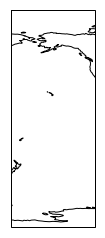

In [21]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

ax.coastlines()
ax.set_extent([170, 240, -90, 90], crs=ccrs.PlateCarree())

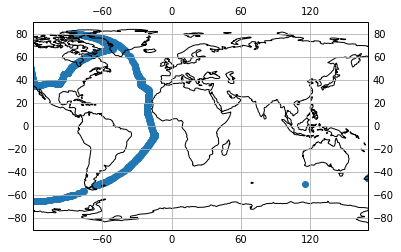

In [14]:
plot_region(sample_lons, sample_lats, r2_points_within, r2_llon, r2_ulon, r2_llat, r2_ulat, 170, -120, -90, 90)

In [ ]:
plot_region(sample_lons, sample_lats, r3_points_within, r3_llon, r3_ulon, r3_llat, r3_ulat, -130, -115, -2, 40)

In [40]:
def plot_region(lons, lats, points_within, ukca_llon, ukca_ulon, ukca_llat, ukca_ulat, llon, ulon, llat, ulat):
    if (abs(llon) <= 180 <= abs(ulon)) or (abs(llon) >= 180 >= abs(ulon)):
        projection = ccrs.PlateCarree(central_longitude=180)
    else:
        projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(projection=projection), facecolor='w')
    ax.scatter(lons, lats, transform=ccrs.PlateCarree())
    ax.scatter(lons[points_within], lats[points_within], color='r', transform=ccrs.PlateCarree())
    ax.add_patch(mpatches.Rectangle(xy=[ukca_llon, ukca_llat], width=ukca_ulon-ukca_llon, height=ukca_ulat-ukca_llat, facecolor='b', alpha=0.2, transform=ccrs.PlateCarree()))
    ax.plot(grid_lons, grid_lats, color='b', alpha=0.7, transform=ccrs.PlateCarree())
    ax.plot(grid_lons.T, grid_lats.T, color='b', alpha=0.7, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([llon, ulon, llat, ulat], crs=ccrs.PlateCarree())
    ax.gridlines(draw_labels=False)

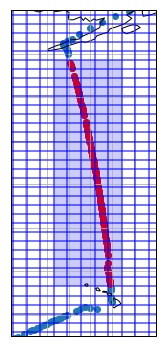

In [41]:
plot_region(sample_lons, sample_lats, r1_points_within, r1_llon, r1_ulon, r1_llat, r1_ulat, -170, -150, 15, 60)

In [ ]:
def plot_regions(lons, lats, points_within_regions, ukca_regions_corners, llon, ulon, llat, ulat):
    r1_points_within, r2_points_within, r3_points_within = points_within_regions
    [r1_llon, r1_ulon, r1_llat, r1_ulat] = ukca_regions_corners[0]
    [r2_llon, r2_ulon, r2_llat, r2_ulat] = ukca_regions_corners[1]
    [r3_llon, r3_ulon, r3_llat, r3_ulat] = ukca_regions_corners[2]
    
    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(projection=ccrs.PlateCarree()), facecolor='w')
    ax.scatter(lons, lats, transform=ccrs.PlateCarree())
    ax.scatter(lons[r1_points_within], lats[r1_points_within], color='r', transform=ccrs.PlateCarree())
    ax.scatter(lons[r2_points_within], lats[r2_points_within], color='r', transform=ccrs.PlateCarree())
    ax.scatter(lons[r3_points_within], lats[r3_points_within], color='r', transform=ccrs.PlateCarree())
    ax.add_patch(mpatches.Rectangle(xy=[r1_llon, r1_llat], width=r1_ulon-r1_llon, height=r1_ulat-r1_llat, facecolor='b', alpha=0.2, transform=ccrs.PlateCarree()))
    ax.add_patch(mpatches.Rectangle(xy=[r2_llon, r2_llat], width=r2_ulon-r2_llon, height=r2_ulat-r2_llat, facecolor='b', alpha=0.2, transform=ccrs.PlateCarree()))
    ax.add_patch(mpatches.Rectangle(xy=[r3_llon, r3_llat], width=r3_ulon-r3_llon, height=r3_ulat-r3_llat, facecolor='b', alpha=0.2, transform=ccrs.PlateCarree()))
    ax.set_title('ATom', loc='right')
    ax.set_title(f'{atom_date_strt.strftime("%b %Y")}', loc='left')
    ax.set_extent([llon, ulon, llat, ulat], crs=ccrs.PlateCarree())
    ax.coastlines()
    if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_regions.png', bbox_inches='tight')

In [ ]:
points_within_regions = [r1_points_within, r2_points_within, r3_points_within]
ukca_regions_corners = [[r1_llon, r1_ulon, r1_llat, r1_ulat], [r2_llon, r2_ulon, r2_llat, r2_ulat], [r3_llon, r3_ulon, r3_llat, r3_ulat]]

In [ ]:
plot_regions(sample_lons, sample_lats, points_within_regions, ukca_regions_corners, -160, -115, -2, 75)

#### Process ATom data

In [ ]:
# Convert ATom C2H6, C2H4, C2H2, C3H8, C3H6 to pptvC to match UKCA lumped species, namely C2H6=C2H6+C2H4+C2H2, C3H8=C3H8+C3H6
atom_dswas_c2h6 = atom_dswas['Ethane_WAS']*2 + atom_dswas['Ethene_WAS']*2 + atom_dswas['Ethyne_WAS']*2
atom_dswas_c3h8 = atom_dswas['Propane_WAS']*3 + atom_dswas['Propene_WAS']*3
# Convert xarray dataset with observational data to pandas dataframe
atom_c2h6 = atom_dswas_c2h6.to_dataframe(name='Lumped_C2H6_C2H4_C2H2')
atom_c3h8 = atom_dswas_c3h8.to_dataframe(name='Lumped_C3H8_C3H6')
atom_nc4h10 = atom_dswas['n-Butane_WAS'].to_dataframe()
atom_ic4h10 = atom_dswas['i-Butane_WAS'].to_dataframe()
atom_nc5h12 = atom_dswas['n-Pentane_WAS'].to_dataframe()
atom_ic5h12 = atom_dswas['i-Pentane_WAS'].to_dataframe()
atom_meono2 = atom_dswas['MeONO2_WAS'].to_dataframe()
atom_sbuono2 = atom_dswas['2-BuONO2_WAS'].to_dataframe()
atom_n2peono2 = atom_dswas['2-PenONO2_WAS'].to_dataframe()
atom_n3peono2 = atom_dswas['3-PenONO2_WAS'].to_dataframe()
atom_ipeono2 = atom_dswas['3-Methyl-2-BuONO2_WAS'].to_dataframe()

In [ ]:
# Select longitudes and latitudes where ATom data is available
lons_c2h6_notnan = np.where(atom_c2h6.Lumped_C2H6_C2H4_C2H2.isna()==False, sample_lons, atom_c2h6.Lumped_C2H6_C2H4_C2H2)
lats_c2h6_notnan = np.where(atom_c2h6.Lumped_C2H6_C2H4_C2H2.isna()==False, sample_lats, atom_c2h6.Lumped_C2H6_C2H4_C2H2)
lons_c3h8_notnan = np.where(atom_c3h8.Lumped_C3H8_C3H6.isna()==False, sample_lons, atom_c3h8.Lumped_C3H8_C3H6)
lats_c3h8_notnan = np.where(atom_c3h8.Lumped_C3H8_C3H6.isna()==False, sample_lats, atom_c3h8.Lumped_C3H8_C3H6)
lons_nc4h10_notnan = np.where(atom_nc4h10['n-Butane_WAS'].isna()==False, sample_lons, atom_nc4h10['n-Butane_WAS'])
lats_nc4h10_notnan = np.where(atom_nc4h10['n-Butane_WAS'].isna()==False, sample_lats, atom_nc4h10['n-Butane_WAS'])
lons_ic4h10_notnan = np.where(atom_ic4h10['i-Butane_WAS'].isna()==False, sample_lons, atom_ic4h10['i-Butane_WAS'])
lats_ic4h10_notnan = np.where(atom_ic4h10['i-Butane_WAS'].isna()==False, sample_lats, atom_ic4h10['i-Butane_WAS'])
lons_nc5h12_notnan = np.where(atom_nc5h12['n-Pentane_WAS'].isna()==False, sample_lons, atom_nc5h12['n-Pentane_WAS'])
lats_nc5h12_notnan = np.where(atom_nc5h12['n-Pentane_WAS'].isna()==False, sample_lats, atom_nc5h12['n-Pentane_WAS'])
lons_ic5h12_notnan = np.where(atom_ic5h12['i-Pentane_WAS'].isna()==False, sample_lons, atom_ic5h12['i-Pentane_WAS'])
lats_ic5h12_notnan = np.where(atom_ic5h12['i-Pentane_WAS'].isna()==False, sample_lats, atom_ic5h12['i-Pentane_WAS'])
lons_meono2_notnan = np.where(atom_meono2['MeONO2_WAS'].isna()==False, sample_lons, atom_meono2['MeONO2_WAS'])
lats_meono2_notnan = np.where(atom_meono2['MeONO2_WAS'].isna()==False, sample_lats, atom_meono2['MeONO2_WAS'])
lons_sbuono2_notnan = np.where(atom_sbuono2['2-BuONO2_WAS'].isna()==False, sample_lons, atom_sbuono2['2-BuONO2_WAS'])
lats_sbuono2_notnan = np.where(atom_sbuono2['2-BuONO2_WAS'].isna()==False, sample_lats, atom_sbuono2['2-BuONO2_WAS'])
lons_n2peono2_notnan = np.where(atom_n2peono2['2-PenONO2_WAS'].isna()==False, sample_lons, atom_n2peono2['2-PenONO2_WAS'])
lats_n2peono2_notnan = np.where(atom_n2peono2['2-PenONO2_WAS'].isna()==False, sample_lats, atom_n2peono2['2-PenONO2_WAS'])
lons_n3peono2_notnan = np.where(atom_n3peono2['3-PenONO2_WAS'].isna()==False, sample_lons, atom_n3peono2['3-PenONO2_WAS'])
lats_n3peono2_notnan = np.where(atom_n3peono2['3-PenONO2_WAS'].isna()==False, sample_lats, atom_n3peono2['3-PenONO2_WAS'])
lons_ipeono2_notnan = np.where(atom_ipeono2['3-Methyl-2-BuONO2_WAS'].isna()==False, sample_lons, atom_ipeono2['3-Methyl-2-BuONO2_WAS'])
lats_ipeono2_notnan = np.where(atom_ipeono2['3-Methyl-2-BuONO2_WAS'].isna()==False, sample_lats, atom_ipeono2['3-Methyl-2-BuONO2_WAS'])

In [ ]:
def plot_ts(atom, alts):
    fig, ax = plt.subplots()
    ax.plot(atom, marker='o')
    ax2 = ax.twinx()
    ax2.plot(alts, marker='o', color='grey', linestyle='--')

In [ ]:
plot_ts(atom_meono2[r1_points_within].values, atom_dsmms.G_ALT[r1_points_within].data)

In [ ]:
plot_ts(atom_meono2[r2_points_within].values, atom_dsmms.G_ALT[r2_points_within].data)

In [ ]:
plot_ts(atom_meono2[r3_points_within].values, atom_dsmms.G_ALT[r3_points_within].data)

In [ ]:
# Choose bins
alt_bins = np.arange(0, 14000, 500)
alt_bin_inds = np.arange(0, len(alt_bins)-1, 1)
alt_bin_mids = np.arange(250, 13500, 500)
alt_r1_bin_inds = np.digitize(atom_dsmms.G_ALT.data[r1_points_within], alt_bins)
alt_r2_bin_inds = np.digitize(atom_dsmms.G_ALT.data[r2_points_within], alt_bins)
alt_r3_bin_inds = np.digitize(atom_dsmms.G_ALT.data[r3_points_within], alt_bins)

# Bin observational data
atom_meono2_r1_mean = atom_meono2[r1_points_within].groupby(alt_r1_bin_inds).mean().reindex(index=alt_bin_inds, fill_value=np.nan)
atom_meono2_r1_std = atom_meono2[r1_points_within].groupby(alt_r1_bin_inds).std().reindex(index=alt_bin_inds, fill_value=np.nan)

atom_meono2_r2_mean = atom_meono2[r2_points_within].groupby(alt_r2_bin_inds).mean().reindex(index=alt_bin_inds, fill_value=np.nan)
atom_meono2_r2_std = atom_meono2[r2_points_within].groupby(alt_r2_bin_inds).std().reindex(index=alt_bin_inds, fill_value=np.nan)

atom_meono2_r3_mean = atom_meono2[r3_points_within].groupby(alt_r3_bin_inds).mean().reindex(index=alt_bin_inds, fill_value=np.nan)
atom_meono2_r3_std = atom_meono2[r3_points_within].groupby(alt_r3_bin_inds).std().reindex(index=alt_bin_inds, fill_value=np.nan)

#### Process UKCA data

In [ ]:
# Find coordinate bounds for calculating area weights
cubes2process = iris.cube.CubeList([cb_c2h6, cb_c3h8, cb_nc4h10, cb_ic4h10, cb_nc5h12, cb_ic5h12, cb_meono2, cb_sbuono2, cb_n2peono2, cb_n3peono2, cb_ipeono2])
for cube in cubes2process:
    for coord in ['longitude', 'latitude']:
            if not cube.coord(coord).has_bounds():
                cube.coord(coord).guess_bounds()

In [ ]:
# Calculate area weights for each region for correct calculation of the mean
any_cube = cb_nc4h10
regions = []
for corners in ukca_regions_corners:
#     llon, ulon, llat, ulat = corners
#     _constr = iris.Constraint(longitude=lambda cell: llon <= cell <= ulon, 
#                               latitude=lambda cell: llat <= cell <= ulat)
    _constr = iris.Constraint(longitude=lambda cell: corners[0] <= cell <= corners[1], 
                              latitude=lambda cell: corners[2] <= cell <= corners[3])
    any_cube_extr = any_cube.extract(_constr)
    weights_cube = any_cube_extr.copy(data=iris.analysis.cartography.area_weights(any_cube_extr))
    weights_cube.rename('area_weights')
    regions.append(
         {'corners': {k: v for k, v in zip(['llon', 'ulon', 'llat', 'ulat'], corners)},
          'area_weights': weights_cube})

In [ ]:
# Calculate regional mean vertical profiles and standart deviations for each altitude
stats = ('MEAN', 'STD_DEV')
ukca_regional_vps3 = []
for region in regions:
    _cube_dict = {}
    corners = region['corners']
    lonlat_constr = iris.Constraint(longitude=lambda cell: corners['llon'] <= cell <= corners['ulon'], 
                                    latitude=lambda cell: corners['llat'] <= cell <= corners['ulat'])    
    for cube in cubes2process.extract(lonlat_constr):
        _stat_dict = {}
        for stat in stats:
            _cubelist = iris.cube.CubeList()
            for i, (lbound, ubound) in enumerate(zip(alt_bins[:-1], alt_bins[1:])):
                alt_constraint = iris.Constraint(altitude=lambda cell: lbound < cell <= ubound)              
                cube_extr = cube.extract(alt_constraint)
                if stat == 'MEAN':
                    kwargs = {'weights': region['area_weights'].extract(alt_constraint).data}
                else:
                    kwargs = {}
                _cubelist.append(cube_extr.collapsed(['longitude', 'latitude', 'altitude'], getattr(iris.analysis, stat), **kwargs))
            _stat_dict[stat] = _cubelist.merge_cube()
        _cube_dict[cube.name()] = _stat_dict
    ukca_regional_vps3.append(_cube_dict)

#### Plot region average vertical profile

In [ ]:
def plot_vp(atom_mean, ukca_mean, atom_std, ukca_std, species, ppn, nregion, picname):
    '''Plot area averaged vertical profile.'''
    fig, ax = plt.subplots(figsize=(7,7), facecolor='w')
    ax.errorbar(atom_mean, alt_bin_mids, xerr=atom_std, color='k')
    ax.errorbar(ukca_mean, alt_bin_mids, xerr=ukca_std, color='r')
    # common
    ax.set_title(f'{species}, {ppn}', loc='right')
    ax.set_title(f'{nregion}', loc='center')
    ax.set_title(f'{atom_date_strt.strftime("%b %Y")}', loc='left')
    ax.set_ylabel('Altitude, km')
    ax.set_ylim(-200,13500)
    ax.set_yticks(alt_bins)
    ax.set_yticklabels(map(int,(alt_bins/1000)))
    ax.legend(['ATom', f'UKCA {ukca_run_name} montly mean'], frameon=False)
    for ytcklbl in ax.yaxis.get_ticklabels()[1::2]:
        ytcklbl.set_visible(False)
    if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_{picname}.png', bbox_inches='tight')

In [ ]:
plot_vp(atom_meono2_r1_mean.values, ukca_meono2_r1_mean.data, atom_meono2_r1_std.values, ukca_meono2_r1_std.data, str_meono2, 'pptv', 'Alaska', 'vp_r1_RONO2_C1')

In [ ]:
plot_vp(atom_meono2_r2_mean.values, ukca_meono2_r2_mean.data, atom_meono2_r2_std.values, ukca_meono2_r2_std.data, str_meono2, 'pptv', 'North West Pacific', 'vp_r2_RONO2_C1')

In [ ]:
plot_vp(atom_meono2_r3_mean.values, ukca_meono2_r3_mean.data, atom_meono2_r3_std.values, ukca_meono2_r3_std.data, str_meono2, 'pptv', 'Central West Pacific', 'vp_r3_RONO2_C1')

In [ ]:
plot_vp(atom_meono2_r3_mean.values, ukca_regional_vps[0]['meono2']['MEAN'].data, atom_meono2_r3_std.values, ukca_regional_vps[0]['meono2']['STD_DEV'].data, str_meono2, 'pptv', 'Central West Pacific', 'vp_r3_RONO2_C1')